In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Data 전처리

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx].split(".")[0]
        img_path = os.path.join(self.image_dir, img_name+".jpg")
        label_path = os.path.join(self.label_dir, img_name+".npz")
        image = Image.open(img_path)#.convert("RGB")
        label = np.load(label_path)['data']
        label = np.transpose(label,(2,0,1))
        
        label = torch.from_numpy(label).float()
        
        if self.transform:
            image = self.transform(image)
        
        label = transforms.Resize((512,512),interpolation=transforms.InterpolationMode.NEAREST)(label)

        return image, label

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),  # 모델에 맞는 크기 조정
])

train_dataset = CustomDataset(
    image_dir="/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/train/image/",
    label_dir="/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/train/label/",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True,weights=None, num_classes=56)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
model.classifier[-1] = nn.Sequential(
    nn.Conv2d(256, 56, kernel_size=1),
    nn.Sigmoid()
)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")
    

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using GPU: NVIDIA GeForce RTX 3090


In [ ]:
num_epochs = 50
criterion = nn.BCELoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    num_steps = 1
    
    for images, labels in train_loader:
        if images.shape!=torch.Size([4, 3, 512, 512]):
            continue
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']  # Model output
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        if num_steps%250 == 0:
            print(f"step : {num_steps}, loss : {epoch_loss/num_steps}")
        num_steps+=1
        
    
    # Calculate average loss and miou
    epoch_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f},')

In [56]:
1+1

2

# Validation Result Visualization

In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),  # 모델에 맞는 크기 조정
])

valid_dataset = CustomDataset(
    image_dir="/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/val/image/",
    label_dir="/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/val/label/",
    transform=transform
)

valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

In [62]:
def gen_img():
    for img,label in valid_loader:
        yield img,label

test_img_gen = gen_img()

In [68]:
img,label = next(test_img_gen)
img = img.to(device)
label = label.to(device)

model.eval()
with torch.no_grad():
    output = model(img)

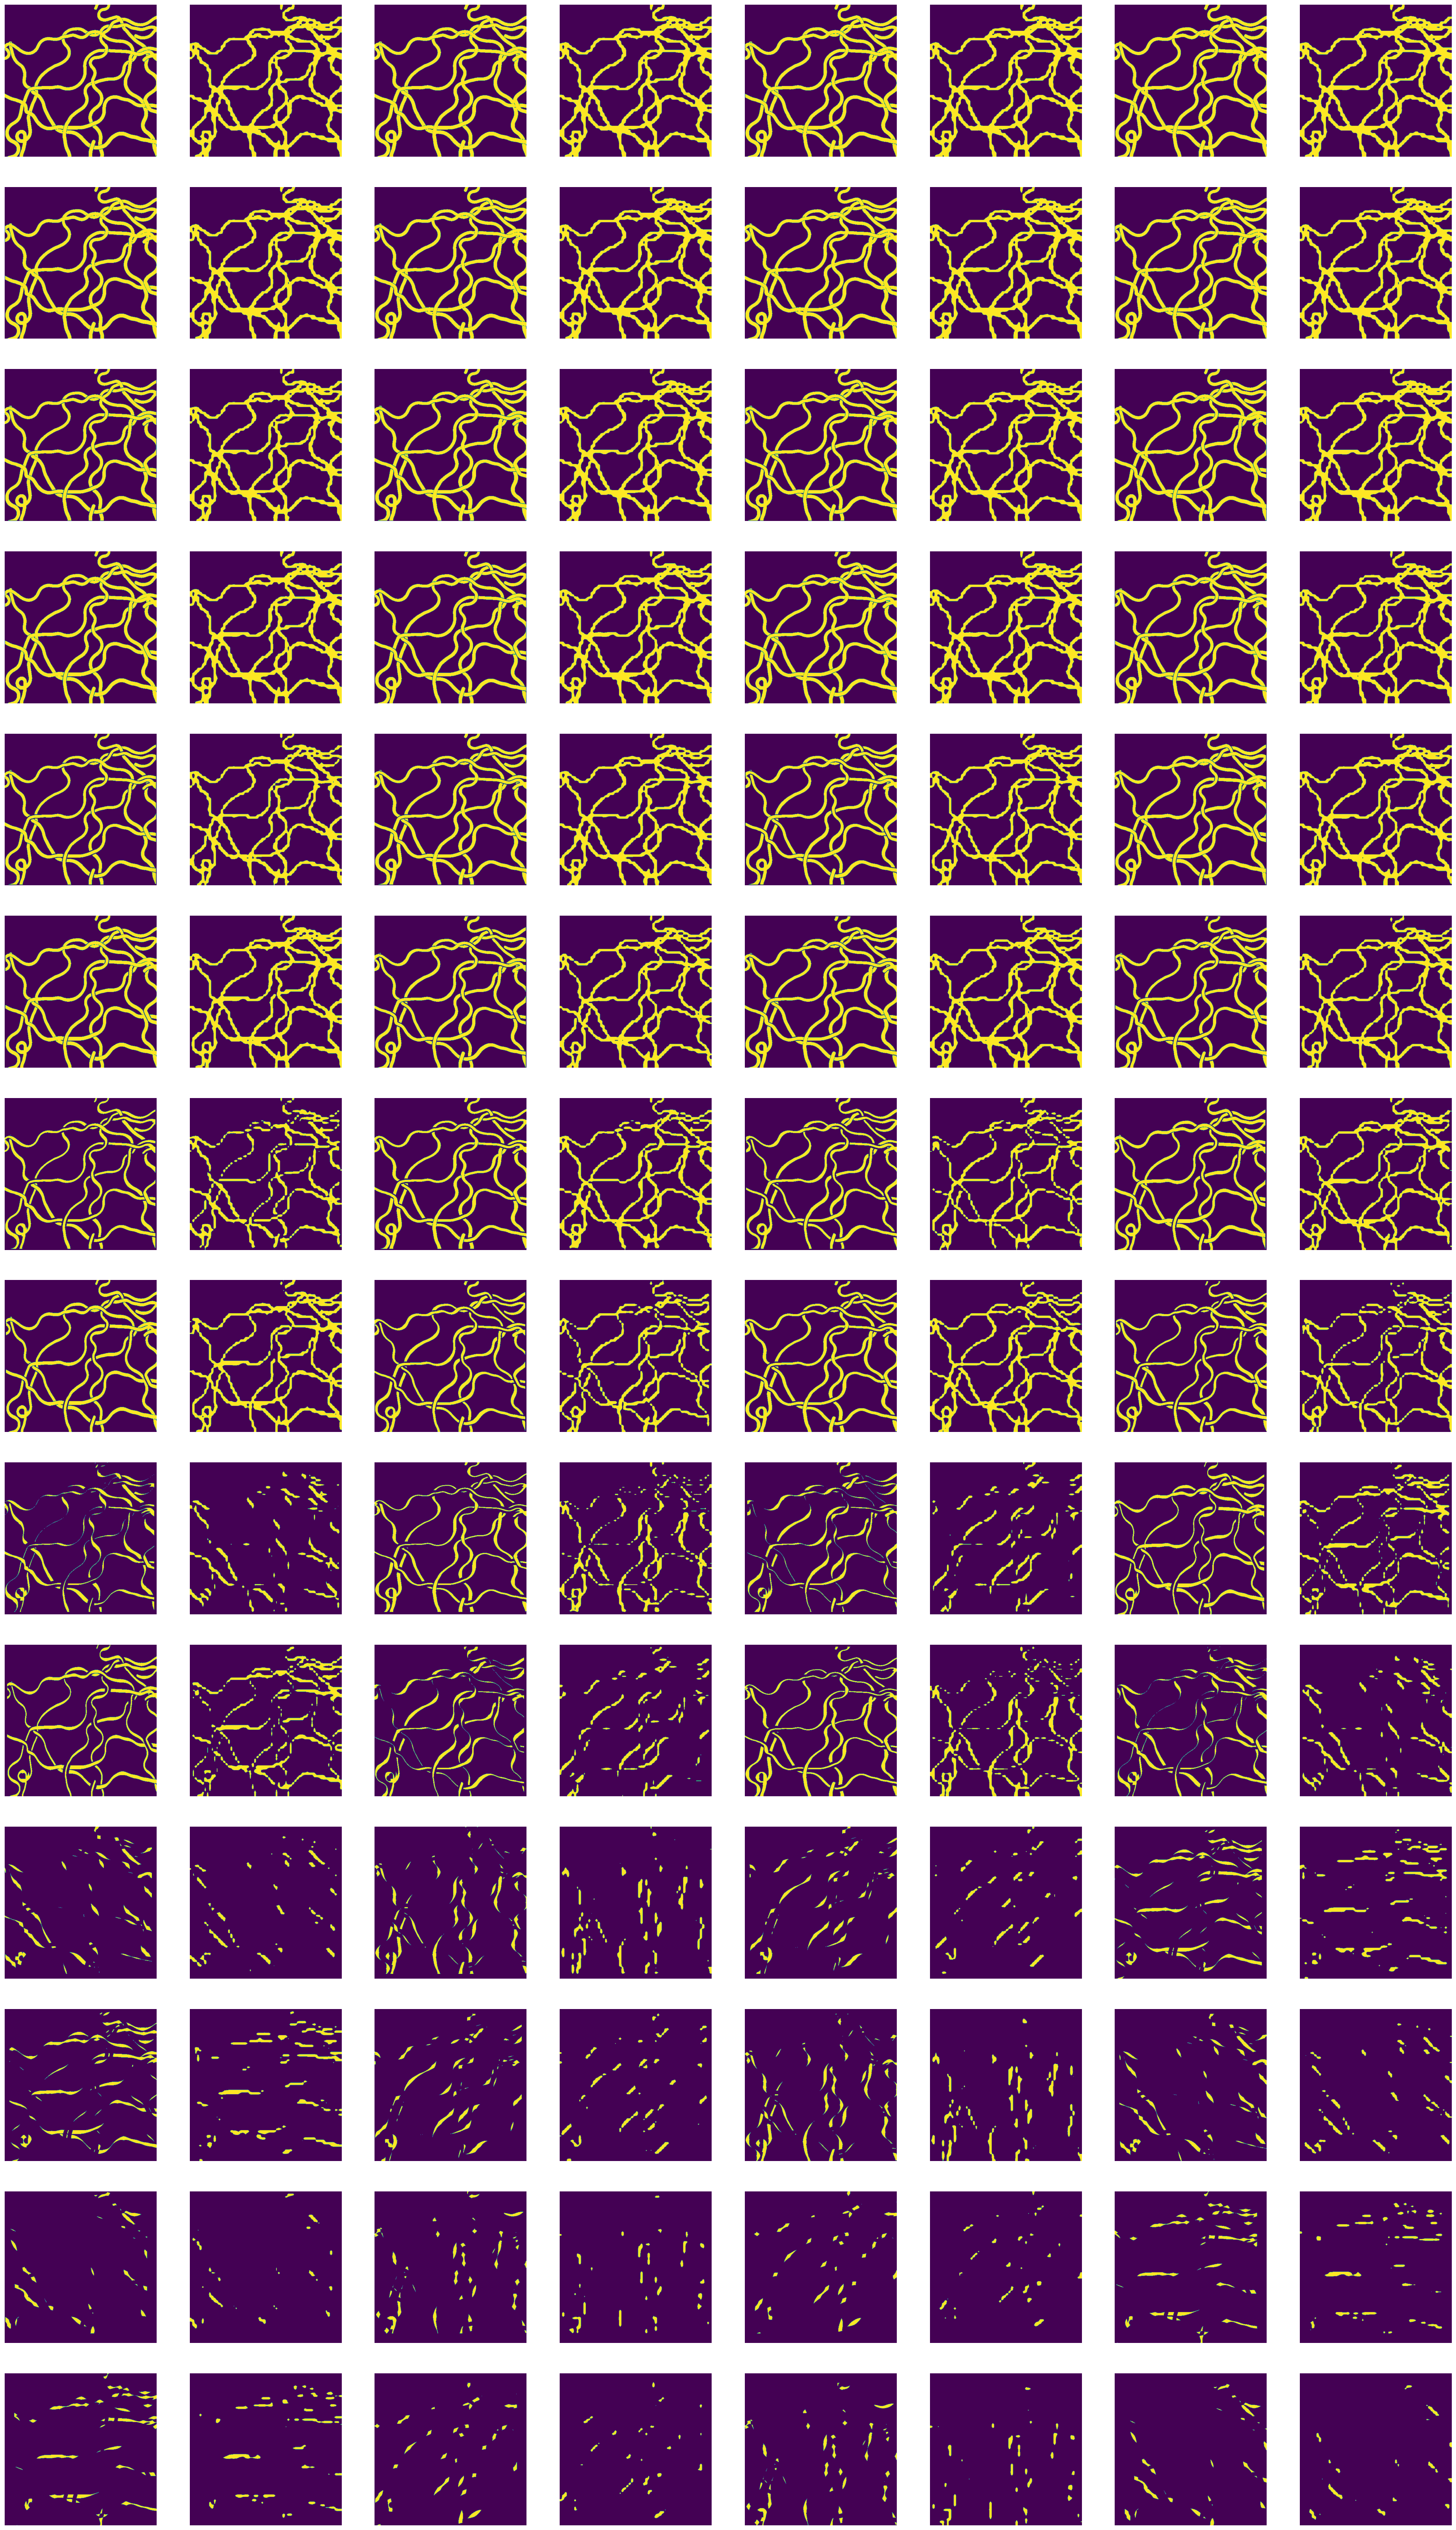

In [54]:
model_idx = 0
plt.figure(figsize=(40,70))
idx=1
for i in range(0,56):
    plt.subplot(14,8,idx)
    plt.imshow(np.transpose(label[model_idx].cpu(),(1,2,0))[...,i])
    plt.axis("off")
    idx+=1
    
    plt.subplot(14,8,idx)
    plt.imshow((np.transpose(output['out'][model_idx].cpu(),(1,2,0))[...,i])>0.5)
    plt.axis("off")
    idx+=1

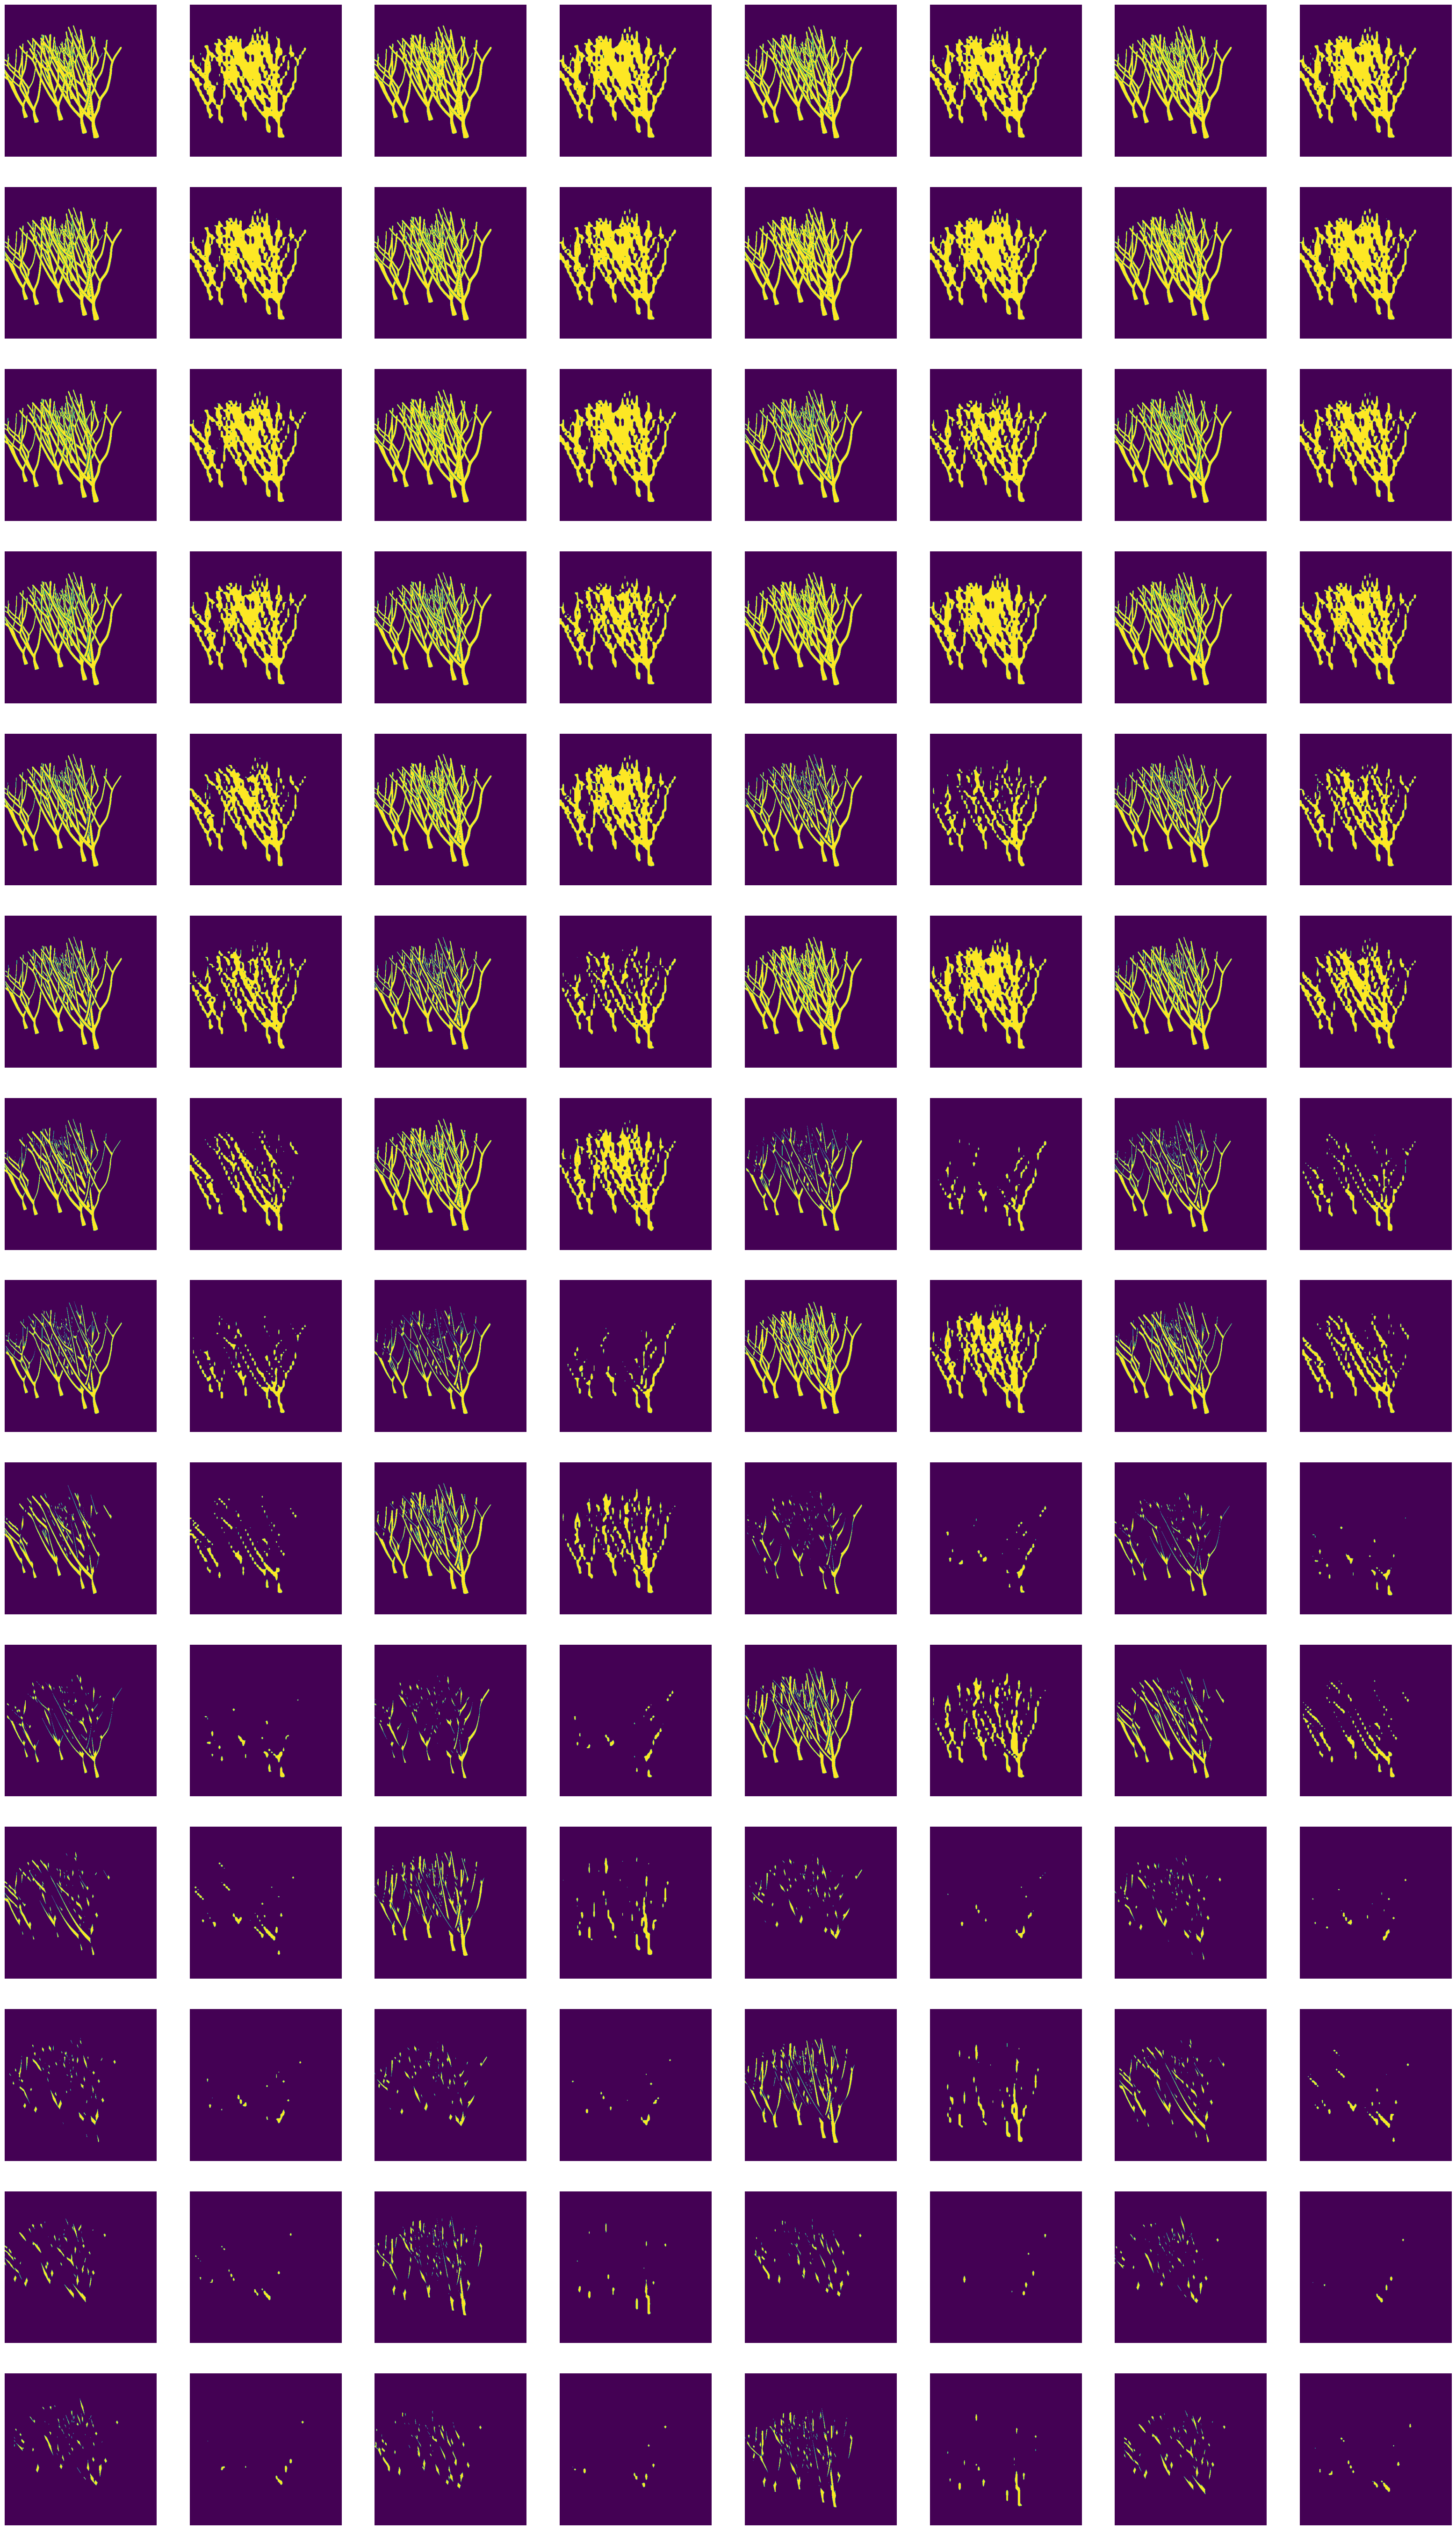

In [70]:
model_idx = 1
plt.figure(figsize=(40,70))
idx=1
for i in range(0,56):
    plt.subplot(14,8,idx)
    plt.imshow(np.transpose(label[model_idx].cpu(),(1,2,0))[...,i])
    plt.axis("off")
    idx+=1
    
    plt.subplot(14,8,idx)
    plt.imshow((np.transpose(output['out'][model_idx].cpu(),(1,2,0))[...,i])>0.5)
    plt.axis("off")
    idx+=1

In [37]:
torch.save(model.state_dict(), 'affinity_last_2.pth')

In [6]:
model.load_state_dict(torch.load("affinity_last_2.pth"))

<All keys matched successfully>

In [91]:
tem_img = cv2.imread("/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/train/image/2000.jpg")
tem_lable = np.load("/root/jupyter/MOON/NEW_PROJECT/ishape/ishape_dataset/_affinity/train/label/2000.npz")['data']

# test image

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512)),  # 모델에 맞는 크기 조정
])

test_dataset = CustomDataset(
    image_dir="./test/",
    label_dir="./test_aff/",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [8]:
def gen_img():
    for img,label in test_loader:
        yield img,label

test_img_gen = gen_img()

In [9]:
img,_ = next(test_img_gen)

In [10]:
img = img.to(device)

model.eval()
with torch.no_grad():
    output = model(img)

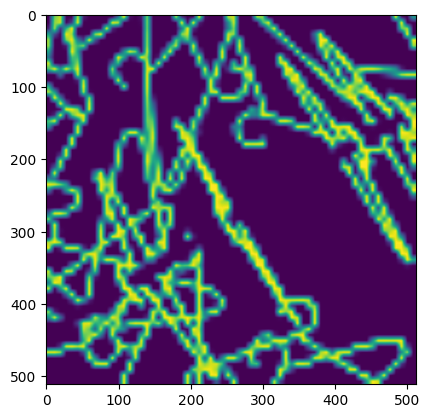

In [11]:
plt.imshow(output['out'][0,0].cpu())

In [15]:
np.save("./merge_aff.npy",output['out'][0].cpu())